In [1]:
%matplotlib inline


from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py
import os

from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import calculate_stats, build_lfp_grid
from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.cells.activecell import ActiveCell
from cell_inference.cells.passivecell import PassiveCell
from cell_inference.cells.simulation import Simulation
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.config import paths, params
from cell_inference.utils.feature_extractors.parameterprediction import ClassifierTypes, ClassifierBuilder

cell_type = CellTypes.ACTIVE

h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD,index_col='id')
h.tstop = params.TSTOP
h.dt = params.DT

In [2]:
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere
from tqdm.notebook import tqdm

DATA_PATH = 'cell_inference/resources/simulation_data'
TRIAL_PATH = os.path.join(DATA_PATH, 'Loc2Alt_Ori2_params')

LFP_PATH = os.path.join(TRIAL_PATH, 'lfp.npz')  # LFP and labels

lfp   = np.load(LFP_PATH)['x']
print(lfp.shape)
labels = np.load(LFP_PATH)['y']
print(labels.shape)

summ_stats = []
for i in tqdm(range(lfp.shape[0])):
    g_lfp, _ = build_lfp_grid(lfp[i], params.ELECTRODE_POSITION)
    summ_stats.append(calculate_stats(g_lfp))
summ_stats = np.array(summ_stats)

(1000, 176, 384)
(1000, 4)


  0%|          | 0/1000 [00:00<?, ?it/s]

If the user sends h and phi parameters and wants the model to learn directional vectors for orientation, enable this code block

In [3]:
convert_hphi_to_dv = False

if convert_hphi_to_dv:
#     hphi_labels = labels
    dv = hphi2unitsphere(labels)
    dvx, dvy, dvz = tuple(np.hsplit(dv, 3))
    labels = np.concatenate((dvx, dvy, dvz), axis=1)
    print(labels.shape)

In [4]:
from cell_inference.utils.feature_extractors.helperfunctions import train_regression, build_dataloader_from_numpy

data = summ_stats
print(data.shape)

train_loader, test_loader = build_dataloader_from_numpy(input_arr=data, labels_arr=labels, batch_size=2)

(1000, 40)


In [5]:
from cell_inference.utils.feature_extractors.fullyconnectednetwork import FullyConnectedNetwork, ActivationTypes
from cell_inference.utils.feature_extractors.convolutionalnetwork import ConvolutionalNetwork
import torch

# model1 = ConvolutionalNetwork(in_channels=1, num_labels=2)
# model1 = torch.load('cell_inference/resources/results/pytorch_models/16_23_59__01_04_2022.pt')
model1 = FullyConnectedNetwork(in_features=40, out_features=4)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #torch.device("cpu")
model1.to(device)

train_regression(model1, train_loader, test_loader, 300, learning_rate=0.001, decay_rate=0.99, device=device)

  0%|          | 1/300 [00:01<05:18,  1.07s/it]

Training Loss: 333989.6919078827 Validation Loss: 103748.57669401169


  4%|▎         | 11/300 [00:11<05:01,  1.04s/it]

Training Loss: 218946.63365507126 Validation Loss: 77582.19988799095


  7%|▋         | 21/300 [00:22<04:54,  1.06s/it]

Training Loss: 71157.78092133999 Validation Loss: 19125.138824641705


 10%|█         | 31/300 [00:32<04:41,  1.05s/it]

Training Loss: 46647.117418408394 Validation Loss: 17742.668156266212


 14%|█▎        | 41/300 [00:42<04:29,  1.04s/it]

Training Loss: 40384.88682478666 Validation Loss: 19654.8926551342


 17%|█▋        | 51/300 [00:53<04:17,  1.03s/it]

Training Loss: 35558.28036600351 Validation Loss: 13696.552943468094


 20%|██        | 61/300 [01:03<04:09,  1.04s/it]

Training Loss: 30936.111777722836 Validation Loss: 12124.104768633842


 24%|██▎       | 71/300 [01:13<03:59,  1.05s/it]

Training Loss: 27024.640855371952 Validation Loss: 10929.574185848236


 27%|██▋       | 81/300 [01:24<03:44,  1.02s/it]

Training Loss: 23548.882608890533 Validation Loss: 9627.578581571579


 30%|███       | 91/300 [01:34<03:24,  1.02it/s]

Training Loss: 20067.74376565218 Validation Loss: 10118.091714441776


 34%|███▎      | 101/300 [01:44<03:27,  1.04s/it]

Training Loss: 17131.87259733677 Validation Loss: 9960.810032010078


 37%|███▋      | 111/300 [01:55<03:15,  1.03s/it]

Training Loss: 16027.856082260609 Validation Loss: 10745.785390973091


 40%|████      | 121/300 [02:05<03:05,  1.04s/it]

Training Loss: 15269.28997606039 Validation Loss: 10916.334605157375


 44%|████▎     | 131/300 [02:15<02:54,  1.03s/it]

Training Loss: 13393.14862781763 Validation Loss: 11026.562916338444


 47%|████▋     | 141/300 [02:26<02:45,  1.04s/it]

Training Loss: 12619.954651355743 Validation Loss: 10116.61920261383


 50%|█████     | 151/300 [02:36<02:35,  1.05s/it]

Training Loss: 12299.833170175552 Validation Loss: 11564.213045328856


 54%|█████▎    | 161/300 [02:46<02:20,  1.01s/it]

Training Loss: 11416.71192047 Validation Loss: 9610.734127938747


 57%|█████▋    | 171/300 [02:57<02:14,  1.04s/it]

Training Loss: 10213.303886830807 Validation Loss: 8467.517559826374


 60%|██████    | 181/300 [03:07<02:03,  1.04s/it]

Training Loss: 9511.330317437649 Validation Loss: 7390.986285507679


 64%|██████▎   | 191/300 [03:17<01:52,  1.04s/it]

Training Loss: 8948.311367303133 Validation Loss: 8519.42886903882


 67%|██████▋   | 201/300 [03:28<01:43,  1.04s/it]

Training Loss: 8629.251039385796 Validation Loss: 9077.902833938599


 70%|███████   | 211/300 [03:38<01:32,  1.04s/it]

Training Loss: 7899.0880699157715 Validation Loss: 8948.788263082504


 74%|███████▎  | 221/300 [03:49<01:22,  1.04s/it]

Training Loss: 7625.7112042456865 Validation Loss: 8734.993261933327


 77%|███████▋  | 231/300 [03:59<01:11,  1.04s/it]

Training Loss: 7212.009586900473 Validation Loss: 8343.838537454605


 80%|████████  | 241/300 [04:09<01:02,  1.05s/it]

Training Loss: 6932.416940152645 Validation Loss: 7659.543713957071


 84%|████████▎ | 251/300 [04:20<00:52,  1.06s/it]

Training Loss: 6593.972183763981 Validation Loss: 7459.9099062383175


 87%|████████▋ | 261/300 [04:31<00:41,  1.06s/it]

Training Loss: 6282.55734872818 Validation Loss: 7165.313522130251


 90%|█████████ | 271/300 [04:41<00:30,  1.04s/it]

Training Loss: 6128.101771265268 Validation Loss: 7126.343567371368


 94%|█████████▎| 281/300 [04:51<00:19,  1.00s/it]

Training Loss: 5914.213071644306 Validation Loss: 7000.537800371647


 97%|█████████▋| 291/300 [05:02<00:09,  1.05s/it]

Training Loss: 5763.4735016822815 Validation Loss: 6975.642334461212


100%|██████████| 300/300 [05:11<00:00,  1.04s/it]


In [6]:
from sklearn.metrics import r2_score
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere, unitsphere2hphi, trivarnorm2unitsphere

train_loader, test_loader = build_dataloader_from_numpy(input_arr=data, labels_arr=labels, batch_size=128)

x, y = next(iter(test_loader))
model1.eval()
x = x.to(device)
output = model1(x)
output = output.to("cpu").detach().numpy()
y = y.to("cpu").detach().numpy()

# h_out, phi_out = tuple(np.hsplit(unitsphere2hphi(trivarnorm2unitsphere(np.hstack((output[:,0], output[:,1], output[:,2])))),2))
# h_lab, phi_lab = tuple(np.hsplit(unitsphere2hphi(trivarnorm2unitsphere(np.hstack((y[:,0], y[:,1], y[:,2])))),2))

print("R2: {}".format(r2_score(y, output)))

# print("R2 h: {}".format(r2_score(h_lab, h_out)))
# print("R2 phi: {}".format(r2_score(phi_lab, phi_out)))
print(output.shape)
print(y.shape)

R2: 0.21221995139521266
(128, 4)
(128, 4)


<IPython.core.display.Javascript object>


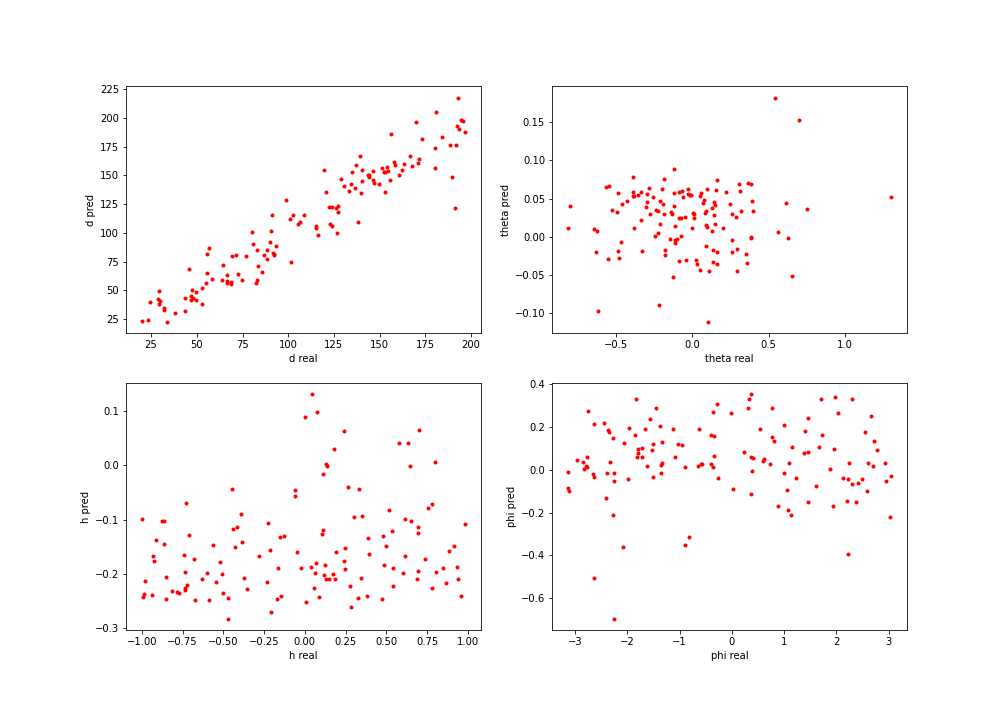

In [9]:
%matplotlib notebook

idx = 0

plt.figure(figsize=(14, 10))
#inf_list = ['r_s', 'l_t', 'r_t', 'r_d', 'r_tu', 'l_d']

# ax_h = plt.subplot(121)
# ax_h.scatter(h_lab, h_out, c='red', marker='.')
# ax_h.set_xlabel('h real')
# ax_h.set_ylabel('h pred')

# ax_p = plt.subplot(122)
# ax_p.scatter(phi_lab, phi_out, c='red', marker='.')
# ax_p.set_xlabel('phi real')
# ax_p.set_ylabel('phi pred')

ax_d = plt.subplot(221)
ax_d.scatter(y[:,0], output[:,0], c='red', marker='.')
ax_d.set_xlabel('d real')
ax_d.set_ylabel('d pred')

ax_t = plt.subplot(222)
ax_t.scatter(y[:,1], output[:,1], c='red', marker='.')
ax_t.set_xlabel('theta real')
ax_t.set_ylabel('theta pred')

ax_h = plt.subplot(223)
ax_h.scatter(y[:,2], output[:,2], c='red', marker='.')
ax_h.set_xlabel('h real')
ax_h.set_ylabel('h pred')

ax_p = plt.subplot(224)
ax_p.scatter(y[:,3], output[:,3], c='red', marker='.')
ax_p.set_xlabel('phi real')
ax_p.set_ylabel('phi pred')

# ax_t = plt.subplot(326)
# ax_t.scatter(y[:,5], output[:,5], c='red', marker='.')
# ax_t.set_xlabel('dendrite length real')
# ax_t.set_ylabel('dendrite length pred')

plt.show()

<IPython.core.display.Javascript object>


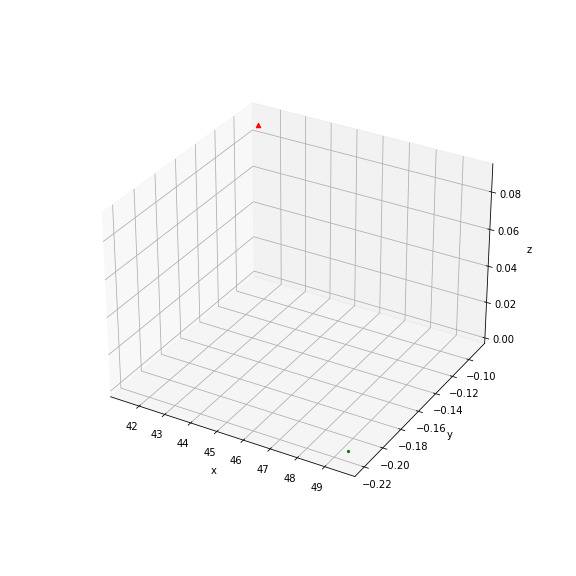

Text(0.5, 0, 'z')

In [8]:
%matplotlib notebook

idx = 0#[0, 1, 2, 3, 4, 5]

plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.scatter3D(y[idx,0], y[idx,1], y[idx,2], c='green', marker='.')
ax.scatter3D(output[idx,0], output[idx,1], output[idx,2], c='red', marker='^')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# plt.show()